In [57]:
import numpy as np
import codecs
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from nltk import Tree
import random
import math
import subprocess
import sys
from collections import deque, Counter, defaultdict, namedtuple, OrderedDict
from scipy.sparse.csgraph import minimum_spanning_tree
import string
import sklearn
import scipy

from tools import dependency, sentence_attentions
from tqdm import tqdm

%matplotlib inline

In [16]:
plt.style.use('PapeFig.mplstyle')

In [4]:
selected_model = 'dev'
if selected_model == 'dev':
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev-conv.conllu'
    no_softmax = False
elif selected_model == 'test':
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest.conllu'
    no_softmax = True
    
elif selected_model == 'fr-cased':
    attention_file = '../BertAA/BertAA-ml-fr-cased/attentions.npz'
    token_file = '../BertAA/BertAA-ml-fr-cased/source.txt'
    conllu_file_name = '../graph-extraction/frdev.conllu'
    no_softmax = True
    

In [139]:
plt.tight_layout()
maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True

dependency_rels = dependency.read_conllu(conllu_file_name,True)

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

token_ids_grouped, words_lists = dependency.group_wordpieces(tokens_loaded, conllu_file_name)

words_lists = {idx : wl for idx, wl in enumerate(words_lists)}

<Figure size 432x288 with 0 Axes>

In [68]:
sentences = range(300)
attention_gen = sentence_attentions.generate_matrices(attentions_loaded, token_ids_grouped, eos, no_softmax, maxlen,sentences)
#attention_gen = enumerate(attention_gen)

viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}

300it [01:54,  2.63it/s]


In [153]:
def plot_head(viss,words_lists, l, h, dep_rels=None,rel_type=None):

    if dep_rels and rel_type:
        probs = np.array([len(dep_rels[i][rel_type])/len(words_lists[i])**2 for i in viss.keys()])
        probs /= probs.sum()
    choices = np.random.choice(list(viss.keys()), 9,replace=False, p=probs)
    fig, axes = plt.subplots(3,3,figsize=(18,18))
    for  ch, ax in zip(choices, axes.ravel()):
        matrix = np.array(viss[ch])
        if type(l) == list or type(h) == list:
            assert len(l) == len(h)
            matrix = np.average(matrix[l,h,:,:], axis=0)
        else:
            matrix = matrix[l,h,:,:]

        im = ax.imshow(matrix,cmap='Greens')
        
        if dep_rels and rel_type:
            for i, j in dep_rels[ch][rel_type]:
                ax.text(j, i, "X", ha="center", va="center", color="red")
        ax.set_title(ch)
        ax.set_xticks(np.arange(len(words_lists[ch])))
        ax.set_yticks(np.arange(len(words_lists[ch])))
        ax.set_xticklabels(words_lists[ch], rotation=90)
        ax.set_yticklabels(words_lists[ch])
    plt.show()
    
    
def plot_head2(viss,words_lists, l, h, dep_rels=None,rel_type=None):
    
    num_rows = len(l) + 1
    if dep_rels and rel_type:
        probs = np.array([len(dep_rels[i][rel_type])/len(words_lists[i])**2 for i in viss.keys()])
        probs /= probs.sum()
    choices = np.random.choice(list(viss.keys()), 3,replace=False, p=probs)
    fig, axes = plt.subplots(num_rows,3,figsize=(num_rows*6,18))
    for  ch, ax_col in zip(choices,axes.transpose()):
        matrices = np.array(viss[ch])

        ax = ax_col[0]
        matrix = np.average(matrices[l,h,:,:], axis=0)
        np.fill_diagonal(matrix, 0)
        im = ax.imshow(matrix,cmap='Blues')
        if dep_rels and rel_type:
            for i, j in dep_rels[ch][rel_type]:
                ax.text(j, i, "X", ha="center", va="center", color="red")
        ax.set_title(f"sentence id: {ch}")
        ax.set_xticks(np.arange(len(words_lists[ch])))
        ax.set_yticks(np.arange(len(words_lists[ch])))
        ax.set_xticklabels(words_lists[ch], rotation=90)
        ax.set_yticklabels(words_lists[ch])
        
        for idx, ax in enumerate(ax_col[1:]):
        
            matrix = matrices[l[idx],h[idx],:,:]
            np.fill_diagonal(matrix, 0)
            im = ax.imshow(matrix,cmap='Blues')
            if dep_rels and rel_type:
                for i, j in dep_rels[ch][rel_type]:
                    ax.text(j, i, "X", ha="center", va="center", color="red")
            ax.set_title((l[idx],h[idx]))
            ax.set_xticks(np.arange(len(words_lists[ch])))
            ax.set_yticks(np.arange(len(words_lists[ch])))
            ax.set_xticklabels(words_lists[ch], rotation=90)
            ax.set_yticklabels(words_lists[ch])
            
        
    plt.show()
    

    
def plot_head3(viss,words_lists,sent_idx, ls, hs, dep_rels,rel_types, title):
    rel2lab = {'adj-modifier-d2p' : 'amod d2p', 'object-d2p': 'obj d2p'}
    rel2mark = {'adj-modifier-d2p': 'A', 'determiner-d2p': 'D', 'auxiliary-d2p': 'X', 'object-d2p': 'O'}
    cmaps = ['Purples', 'Blues']
    to_romans = ['I', 'II', 'III', 'IV']
    num_cols = len(ls)
    num_rows = len(ls[0]) +1
    fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*6,num_cols*6))
    matrices = np.array(viss[sent_idx])
    
    for  idx, ax_col in enumerate(axes.transpose()):
        for jdx, ax in enumerate(ax_col):

            if jdx == 0:
                matrix = np.average(matrices[ls[idx],hs[idx],:,:], axis=0)
            else:
                matrix = matrices[ls[idx][jdx-1],hs[idx][jdx-1],:,:]
            
            
            np.fill_diagonal(matrix, 0)
            im = ax.imshow(matrix,cmap=cmaps[idx% len(cmaps)])
            for i, j in dep_rels[sent_idx][rel_types[idx]]:
                mark = rel2mark[rel_types[idx]]
                ax.text(j, i, mark, ha="center", va="center", color="red")
            if jdx == 0:
                ax.set_title(rel2lab[rel_types[idx]])
                
                head_title = 'AVERAGED'
            else:
                head_title = f'HEAD {to_romans[jdx-1]}'
                
            if jdx == num_rows -1:    
                ax.set_xticks(np.arange(len(words_lists[sent_idx])))
                ax.set_xticklabels(words_lists[sent_idx], rotation=90)
            else:
                ax.set_xticklabels([])

            if idx == 0:
                ax.set_yticks(np.arange(len(words_lists[sent_idx])))
                ax.set_yticklabels(words_lists[sent_idx])
                ax.set_ylabel(head_title)
            else:
                ax.set_yticklabels([])
                
    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
    plt.savefig(title,dpi=300, format='pdf', bbox_inches='tight')
    plt.show()
    
    
def plot_head4(viss,words_lists,sent_idx, ls, hs, dep_rels,rel_types, title):
    cmaps = ['Purples', 'Blues']
    rel2mark = {'adj-modifier-d2p': 'A', 'determiner-d2p': 'D', 'auxiliary-d2p': 'X', 'object-d2p': 'O'}
    
    rel2lab = {'adj-modifier-d2p' : 'amod d2p', 'object-d2p': 'obj d2p'}
    to_romans = ['I', 'II', 'III', 'IV']
    num_cols = len(ls[0]) +1
    num_rows =  len(ls)
    
    fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*6,num_cols*6))
    matrices = np.array(viss[sent_idx])
    
    for  jdx, ax_row in enumerate(axes.transpose()):
        for idx, ax in enumerate(ax_row):

            if jdx == 0:
                matrix = np.average(matrices[ls[idx],hs[idx],:,:], axis=0)
            else:
                matrix = matrices[ls[idx][jdx-1],hs[idx][jdx-1],:,:]
            
            
            np.fill_diagonal(matrix, 0)
            im = ax.imshow(matrix,cmap=cmaps[idx% len(cmaps)])
            for i, j in dep_rels[sent_idx][rel_types[idx]]:
                mark = rel2mark[rel_types[idx]]
                ax.text(j, i, mark, ha="center", va="center", color="red")
            if jdx == 0:
                head_title = 'AVERAGED'
            else:
                head_title = f'HEAD {to_romans[jdx-1]}'
                
            if jdx == 0:    
                ax.set_yticks(np.arange(len(words_lists[sent_idx])))
                ax.set_yticklabels(words_lists[sent_idx])
                ax.set_ylabel(rel2lab[rel_types[idx]])
            else:
                ax.yaxis.set_ticklabels([])

            if idx == num_rows -1:  
                ax.set_xticks(np.arange(len(words_lists[sent_idx])))
                ax.set_xticklabels(words_lists[sent_idx], rotation=90)
            elif idx == 0:
                ax.set_title(head_title)
                ax.set_xticklabels([])
            else:
                ax.set_xticklabels([])
                
    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
    plt.savefig(title,dpi=300,format='pdf', bbox_inches='tight', pad_inches = 0)
    plt.show()

def one_plot_head(viss,words_lists, idx,relation_rules, dep_rels,rel_type):

    fig, ax = plt.subplots(1,1,figsize=(18,18))

    rules = relation_rules[rel_type]
    matrix = np.array(viss[idx])

    matrix = np.average(matrix[rules.layers,rules.heads,:,:], axis=0)


    im = ax.imshow(matrix,cmap='Blues')

    if dep_rels and rel_type:
        for i, j in dep_rels[idx][rel_type]:
            ax.text(j, i, "X", ha="center", va="center", color="red", pad_inches = 0)
    ax.set_title(idx)
    ax.set_xticks(np.arange(len(words_lists[idx])))
    ax.set_yticks(np.arange(len(words_lists[idx])))
    ax.set_xticklabels(words_lists[idx], rotation=90)
    ax.set_yticklabels(words_lists[idx])
    plt.show()

In [8]:
def dep_prob(viss,words_lists,idx ,relation_rules):
    word_list =  words_lists[idx]
    dep_probs= np.zeros((len(word_list),len(relation_rules)))
    matrices = np.array(viss[idx])
    for i, rules in enumerate(relation_rules.values()):
        matrix = np.average(matrices[rules.layers,rules.heads,:,:], axis=0)
        if rules.d2p:
            matrix = matrix.transpose()
        
        np.fill_diagonal(matrix, 0)
        matrix /= matrix.sum(axis=1, keepdims=True)
        dep_probs[:,i] = matrix.mean(axis=0)
    dep_probs /= dep_probs.sum(axis=1, keepdims=True)

    labels = [ k[:3] for k in relation_rules.keys()]
    hide_zeroes=False
    hide_diagonal=False
    hide_threshold=None
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [4])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(word_list):
        print("    %{0}s".format(columnwidth) % label1[:5], end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % dep_probs[i, j]
            print(cell, end=" ")
        print()

In [8]:
'adj-clause-p2d': RelData([4, 7, 6], [5, 6, 5],False, False),
'adj-modifier-d2p': RelData([3, 7, 5], [9, 10, 7],False, True),
'adv-clause-d2p': RelData([4, 4, 3], [9, 3, 1],False, True),
'adv-modifier-d2p': RelData([7, 3, 6], [6, 10, 5],False, True),
'all-d2p': RelData([3, 7, 4], [9, 10, 5],False, True),
'apposition-p2d': RelData([0, 9], [8, 0],False, False),
'auxiliary-d2p': RelData([3, 8, 4], [9, 5, 5],False, True),
'clausal subject-p2d': RelData([8, 0, 0], [10, 8, 5],False, False),
'clausal-d2p': RelData([7, 0, 5], [0, 5, 4],False, True),
'compound-d2p': RelData([3, 7, 5], [9, 6, 7],False, True),
'conjunct-d2p': RelData([4, 6, 0], [3, 0, 1],False, True),
'determiner-d2p': RelData([7, 3, 4], [10, 9, 5],False, True),
'noun-modifier-p2d': RelData([4, 0, 5], [5, 8, 8],False, False),
'num-modifier-d2p': RelData([7, 6, 0], [10, 5, 8],False, True),
'object-d2p': RelData([7, 6, 3], [9, 9, 8],False, True),
'other-d2p': RelData([7, 4, 8], [10, 5, 5],False, True),
'punctuation-p2d': RelData([11, 10, 7], [1, 2, 8],False, False),
'subject-p2d': RelData([7, 4], [11, 10],False, False),

SyntaxError: invalid syntax (<ipython-input-8-5cf8f80e258d>, line 1)

# auxiliary (3, 9)

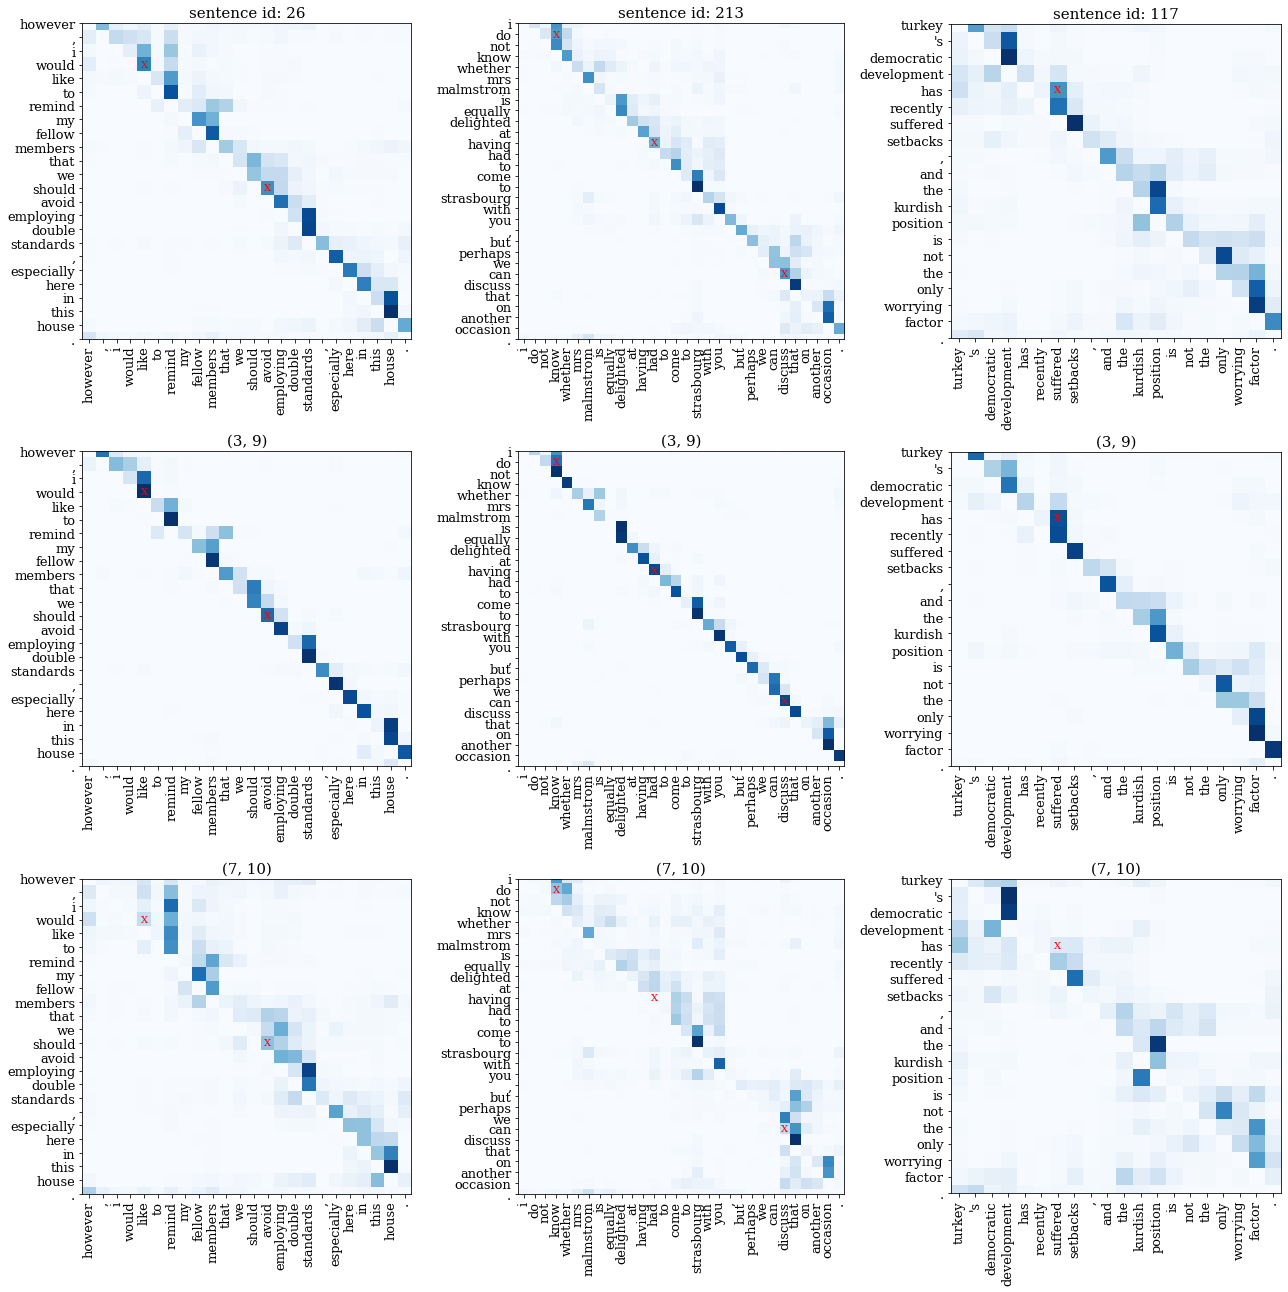

In [95]:
plot_head2(viss,words_lists, [3, 7], [9, 10],dependency_rels, 'auxiliary-d2p')

# clausal head (0, 8)

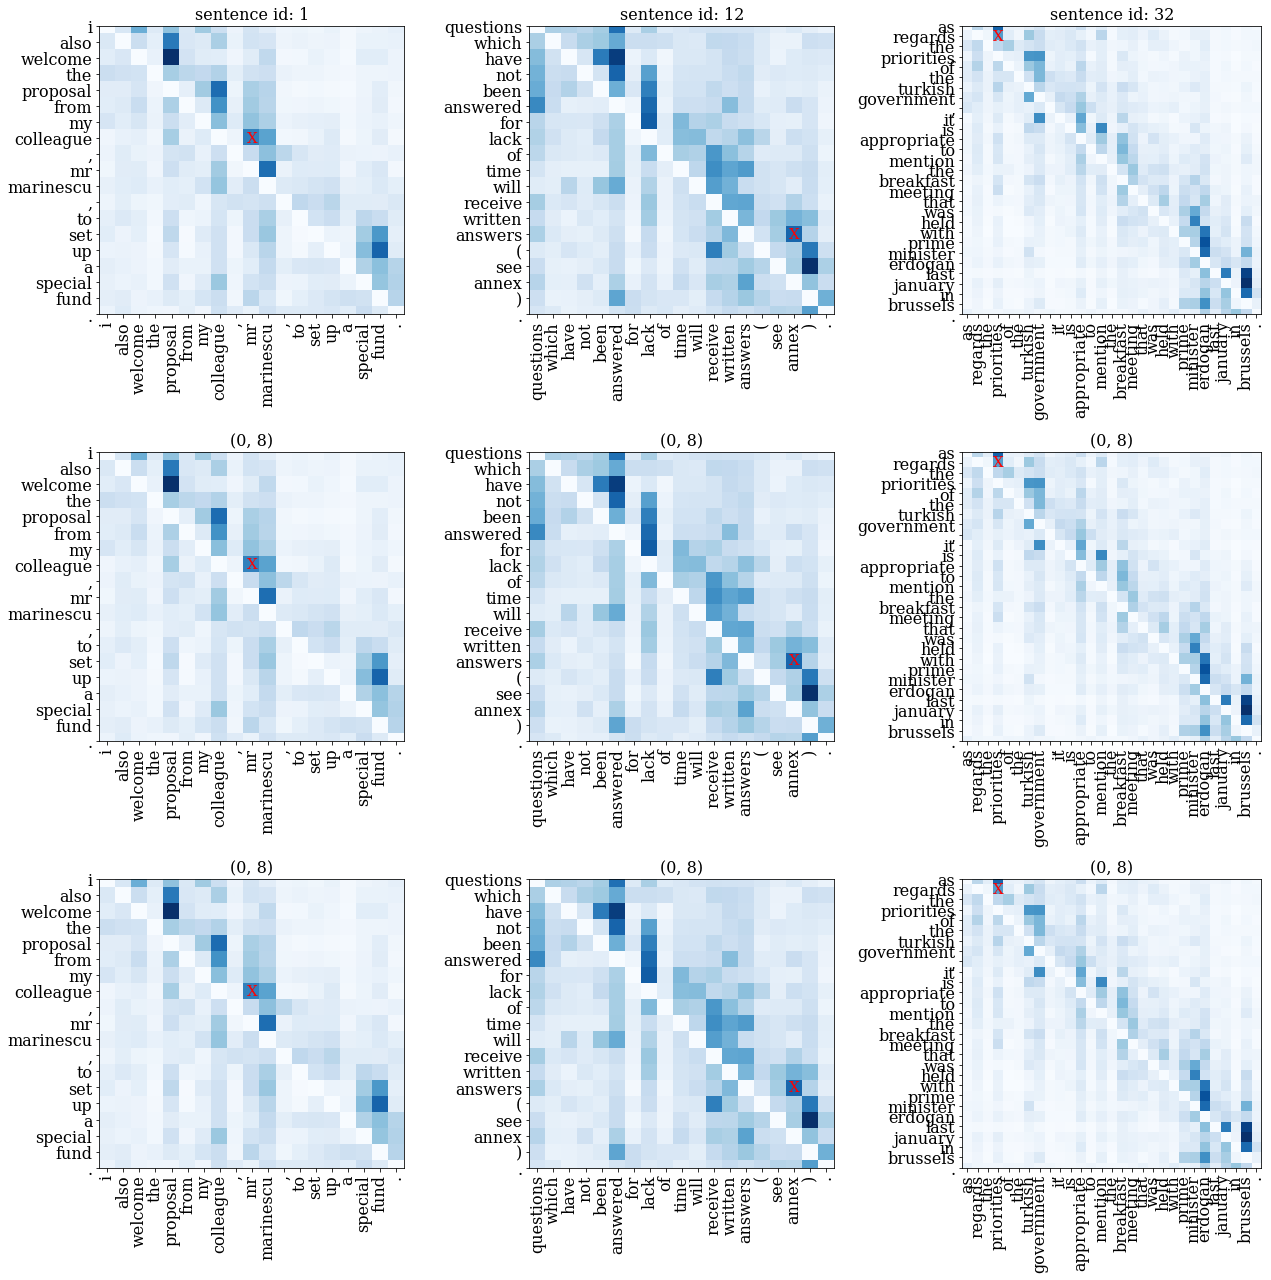

In [20]:
plot_head2(viss,words_lists, [0, 0], [8, 8],dependency_rels, 'apposition-p2d')

## Best subject p2d (dev: 70.4%, test: 68.6%)
### Copula rearanged (dev : 75.4%,  test: 73.8%)

In [20]:
plot_head(viss,words_lists, [4,7,8], [10, 11, 10], dependency_rels, 'subject-p2d')

ValueError: Cannot take a larger sample than population when 'replace=False'

In [52]:
' '.join(words_lists[45])

'( lt ) madam president , safeguarding nuclear safety is an issue relevant for all countries , whether they have nuclear power plants or not .'

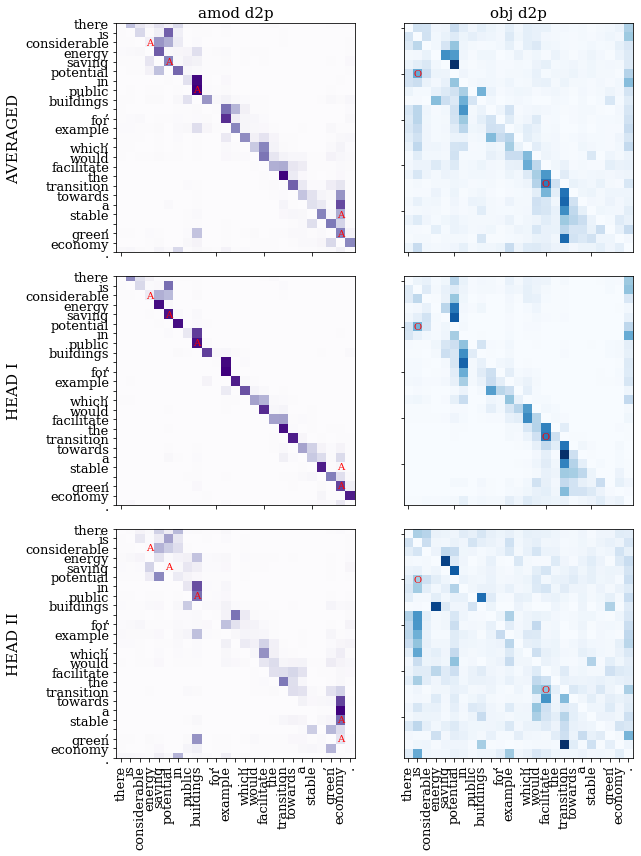

In [154]:
ls = [ [3, 7],[7, 3]] 
hs = [[9,10],[9, 8]]
rel_types = ['adj-modifier-d2p', 'object-d2p']
sent_idx = 17

plot_head3(viss, words_lists, sent_idx, ls, hs, dependency_rels, rel_types, 'HeadAnalysisVertical.pdf')

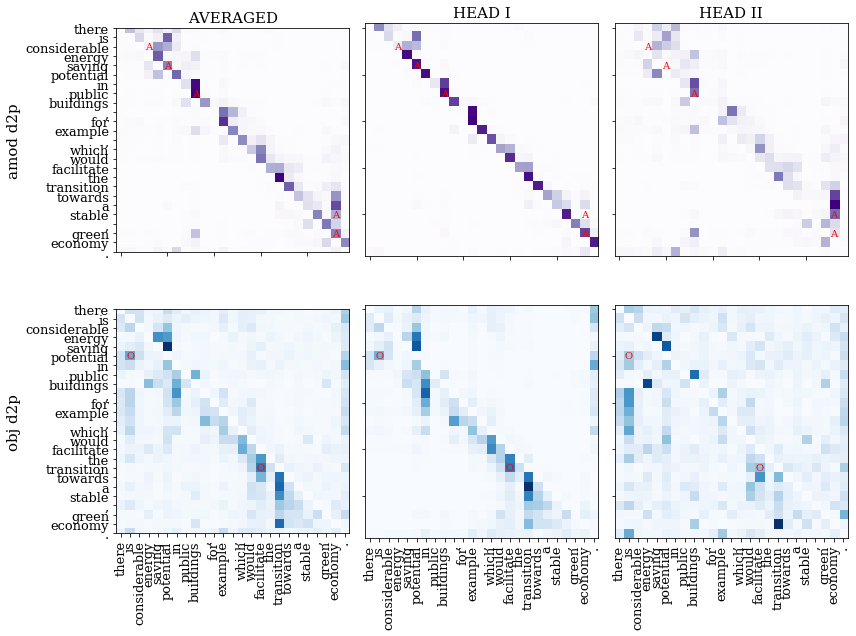

In [155]:
ls = [ [3, 7],[7, 3]] 
hs = [[9,10],[9, 8]]
rel_types = ['adj-modifier-d2p', 'object-d2p']
sent_idx = 17

plot_head4(viss, words_lists, sent_idx, ls, hs, dependency_rels, rel_types, 'HeadAnalysisHorizontal.pdf')

In [58]:

RelData= namedtuple('RelData','layers heads transpose d2p')
RelData2 = namedtuple('RelData', 'layers heads layersT headsT weight weightT')
relation_rules  = OrderedDict(sorted({'adj-clause-p2d': RelData([4, 7, 6, 0], [5, 6, 5, 8],False, False),
    'adj-modifier-d2p': RelData([3, 7, 6, 5], [9, 10, 5, 7],False, True),
    'adv-clause-d2p': RelData([4, 4, 8, 3], [9, 3, 8, 1],False, True),
    'adv-modifier-d2p': RelData([7, 3, 6, 8], [6, 10, 5, 5],False, True),
    'all-d2p': RelData([3, 7, 3, 4], [9, 10, 10, 5],False, True),
    'apposition-p2d': RelData([0, 9], [8, 0],False, False),
    'auxiliary-d2p': RelData([3, 8, 7, 4], [9, 5, 10, 5],False, True),
    'clausal subject-p2d': RelData([8, 0, 0, 0], [10, 8, 5, 1],False, False),
    'clausal-d2p': RelData([7, 5, 4, 8], [0, 4, 6, 8],False, True),
    'compound-d2p': RelData([3, 5, 6, 0], [9, 11, 5, 8],False, True),
    'conjunct-d2p': RelData([4, 6, 1, 5], [3, 0, 10, 4],False, True),
    'determiner-d2p': RelData([7, 3, 4, 8], [10, 9, 5, 10],False, True),
    'noun-modifier-p2d': RelData([4, 0, 0, 3], [5, 8, 1, 3],False, False),
    'num-modifier-d2p': RelData([7, 6, 3, 1], [10, 5, 10, 5],False, True),
    'object-d2p': RelData([7, 6, 4, 5], [9, 9, 6, 3],False, True),
    'other-d2p': RelData([7, 4, 8, 0], [10, 5, 5, 8],False, True),
    'punctuation-p2d': RelData([11, 7, 2, 11], [6, 7, 2, 2],False, False),
    'subject-p2d': RelData([7, 4], [11, 10],False, False),
    'adj-clause-d2p': RelData([6, 4, 0, 8], [4, 6, 3, 10],False, True),
    'adj-modifier-p2d': RelData([3, 5, 0, 4], [5, 1, 2, 7],False, False),
    'adv-clause-p2d': RelData([4, 5, 5, 0], [3, 4, 8, 8],False, False),
    'adv-modifier-p2d': RelData([7, 4, 0, 6], [3, 7, 11, 2],False, False),
    'all-p2d': RelData([1, 0, 7, 0], [4, 2, 4, 11],False, False),
    'apposition-d2p': RelData([4, 0, 4, 3], [3, 9, 9, 8],False, True),
    'auxiliary-p2d': RelData([7, 6, 7, 6], [4, 3, 3, 9],False, False),
    'clausal subject-d2p': RelData([9, 1, 2, 1], [2, 11, 4, 8],False, True),
    'clausal-p2d': RelData([5, 6, 7, 5], [7, 7, 6, 8],False, False),
    'compound-p2d': RelData([3, 6, 0, 7], [5, 5, 2, 4],False, False),
    'conjunct-p2d': RelData([5, 4, 0, 4], [5, 3, 8, 4],False, False),
    'determiner-p2d': RelData([5, 1, 3, 8], [6, 4, 2, 6],False, False),
    'noun-modifier-d2p': RelData([7, 0, 5, 0], [9, 8, 3, 7],False, True),
    'num-modifier-p2d': RelData([7, 9, 1, 0], [11, 4, 10, 8],False, False),
    'object-p2d': RelData([7, 4, 0, 3], [10, 5, 8, 9],False, False),
    'other-p2d': RelData([6, 8], [9, 6],False, False),
    'punctuation-d2p': RelData([4, 8, 3, 7], [5, 5, 9, 5],False, True),
    'subject-d2p': RelData([5, 1, 7, 7], [9, 6, 1, 8],False, True)}.items()))

In [125]:
def one_plot_head(viss,words_lists, idx,relation_rules, dep_rels,rel_type, title):

    fig, ax = plt.subplots(1,1,figsize=(6,6))

    rules = relation_rules[rel_type]
    matrix = np.array(viss[idx])

    matrix = np.average(matrix[rules.layers,rules.heads,:,:], axis=0)
    np.fill_diagonal(matrix, 0)

    im = ax.imshow(matrix,cmap='Greens')

#     if dep_rels and rel_type:
#         for i, j in dep_rels[idx][rel_type]:
#             ax.text(j, i, "X", ha="center", va="center", color="red")
    #ax.set_title('nsubj p2d')
    ax.set_xticks(np.arange(len(words_lists[idx])))
    ax.set_yticks(np.arange(len(words_lists[idx])))
    ax.set_xticklabels(words_lists[idx], rotation=90)
    ax.set_yticklabels(words_lists[idx])
    plt.savefig(title,dpi=300, format='pdf')
    plt.show()

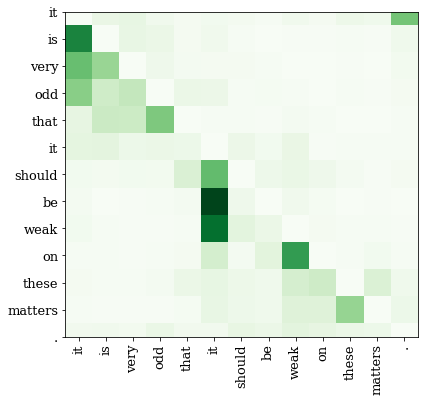

In [126]:
one_plot_head(viss, words_lists, 92, relation_rules, dependency_rels, 'subject-p2d', 'SubjectExpletiveCop.pdf')

In [110]:
def one_plot_head2(viss,words_lists, idx,layers,heads, dep_rels,rel_types, title):

    rel2mark = {'adj-modifier-d2p': 'A', 'determiner-d2p': 'D', 'auxiliary-d2p': 'X', 'object-d2p': 'O'}
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    matrix = np.array(viss[idx])

    matrix = np.average(matrix[layers,heads,:,:], axis=0)

    np.fill_diagonal(matrix, 0)
    im = ax.imshow(matrix,cmap='Purples')

    for rel_type in rel_types:
        mark = rel2mark[rel_type]
        for i, j in dep_rels[idx][rel_type]:
            ax.text(j, i, mark, ha="center", va="center", color="red")
    ax.set_xticks(np.arange(len(words_lists[idx])))
    ax.set_yticks(np.arange(len(words_lists[idx])))
    ax.set_xticklabels(words_lists[idx], rotation=90)
    ax.set_yticklabels(words_lists[idx])
    plt.savefig(title,dpi=300, format='pdf')
    plt.show()

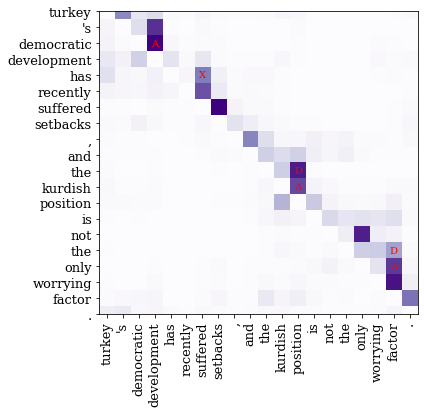

In [120]:
one_plot_head2(viss,words_lists, 117, [3,7], [9,10],dependency_rels, ['adj-modifier-d2p', 'determiner-d2p', 'auxiliary-d2p'], 'MultipurposeHeads.pdf')

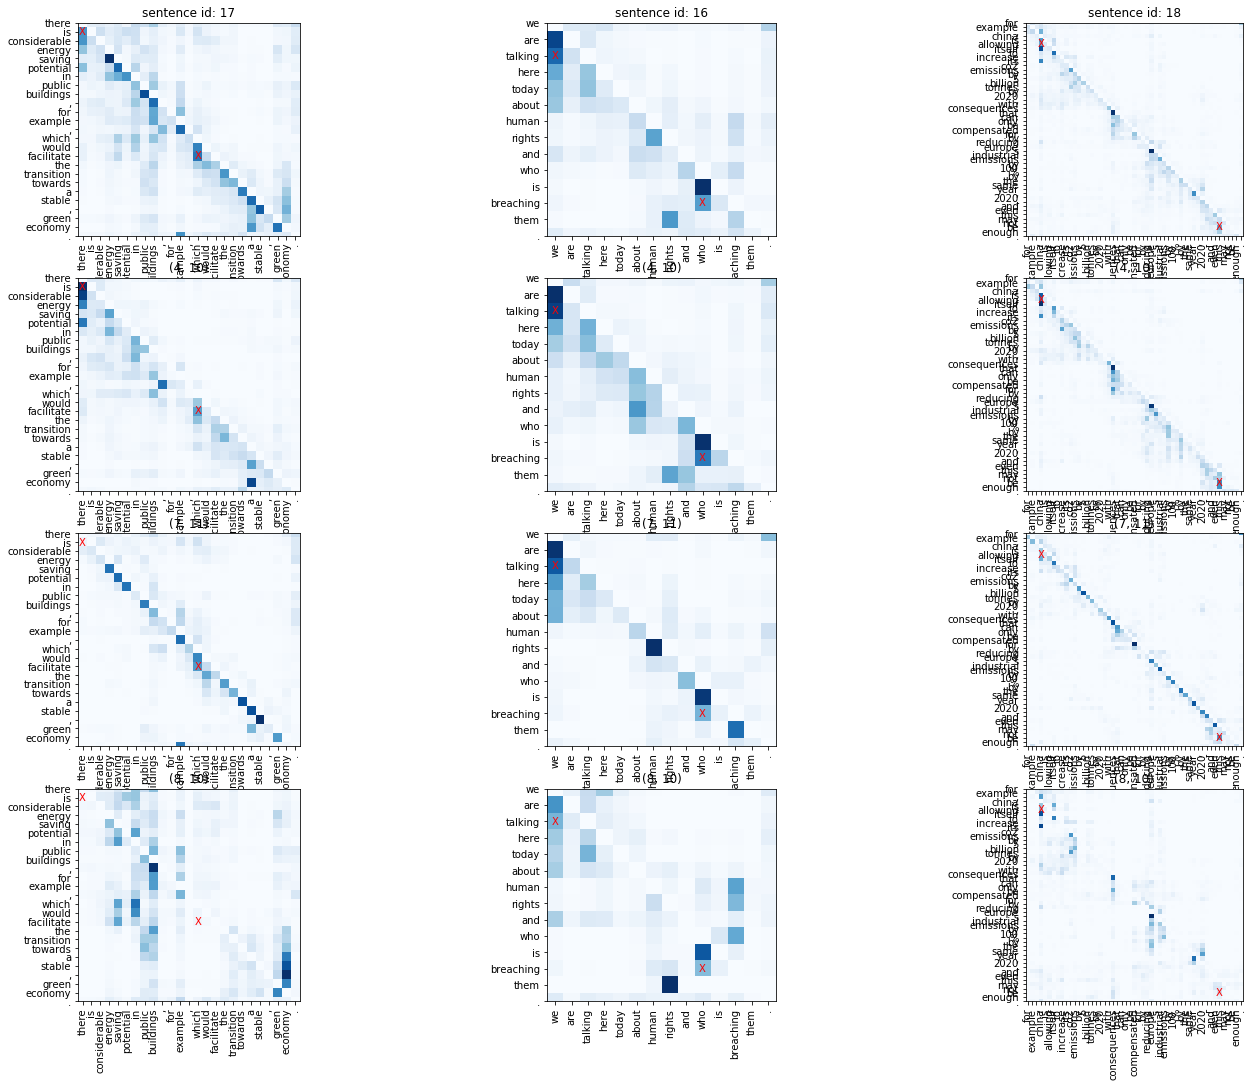

In [12]:
plot_head2(viss,words_lists, [4,7,8], [10, 11, 10], dependency_rels, 'subject-p2d')

## Best subject d2p (dev: 62.6%, test: 60.5%)

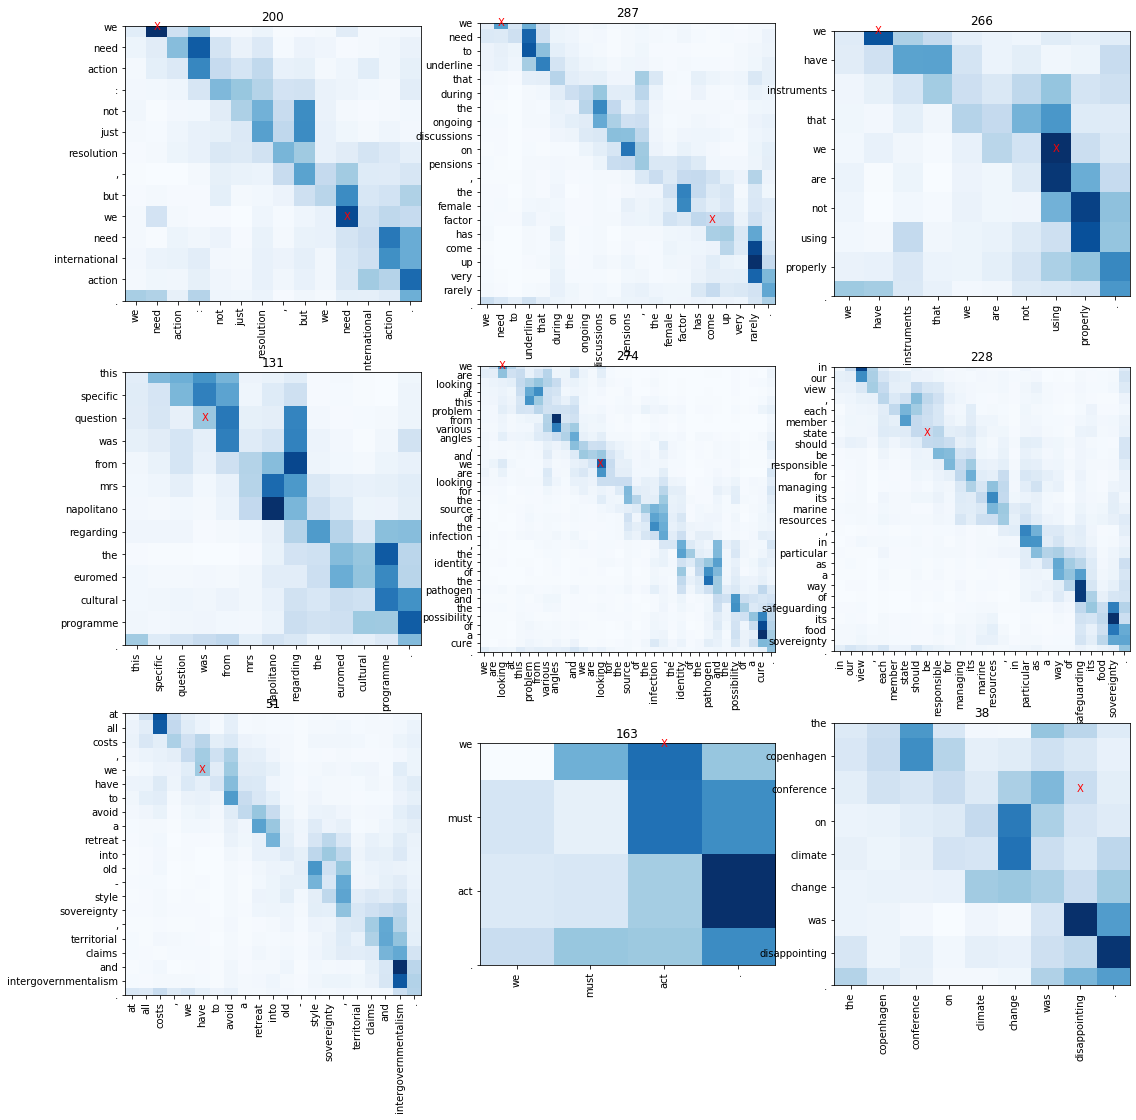

In [8]:
plot_head(viss,words_lists, [5, 4, 7, 6, 7, 8, 3, 5, 0],[ 0,  5,  1,  5,  2,  9,  3, 11,  8], dependency_rels, 'subject-d2p')

## Best object d2p (dev: 82.7%, test: 80.5%)

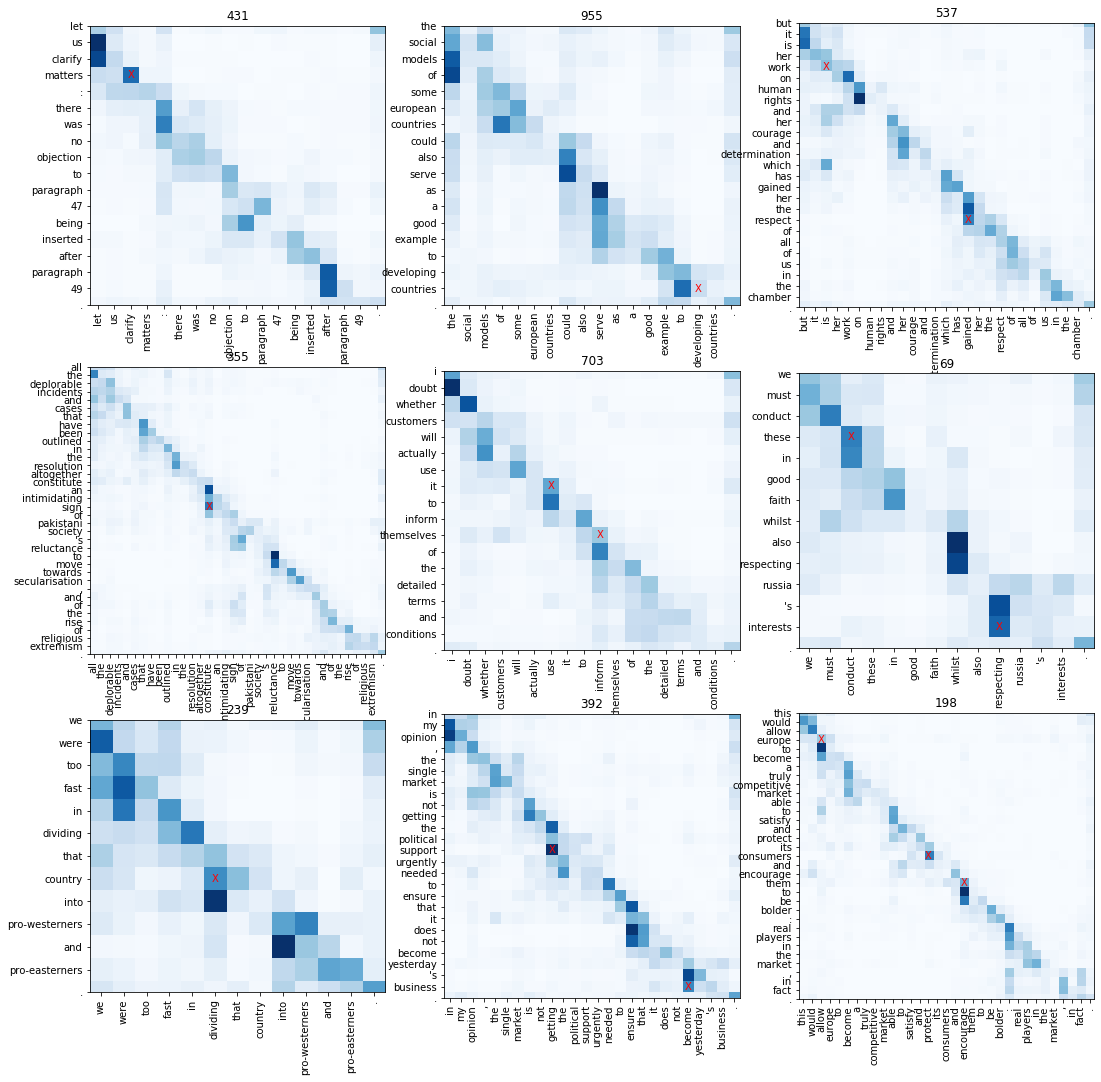

In [33]:
plot_head(viss,words_lists,[7, 6, 3, 6, 4, 6, 5],[ 9,  9, 11, 10,  6,  3,  3], dependency_rels, 'object-d2p')

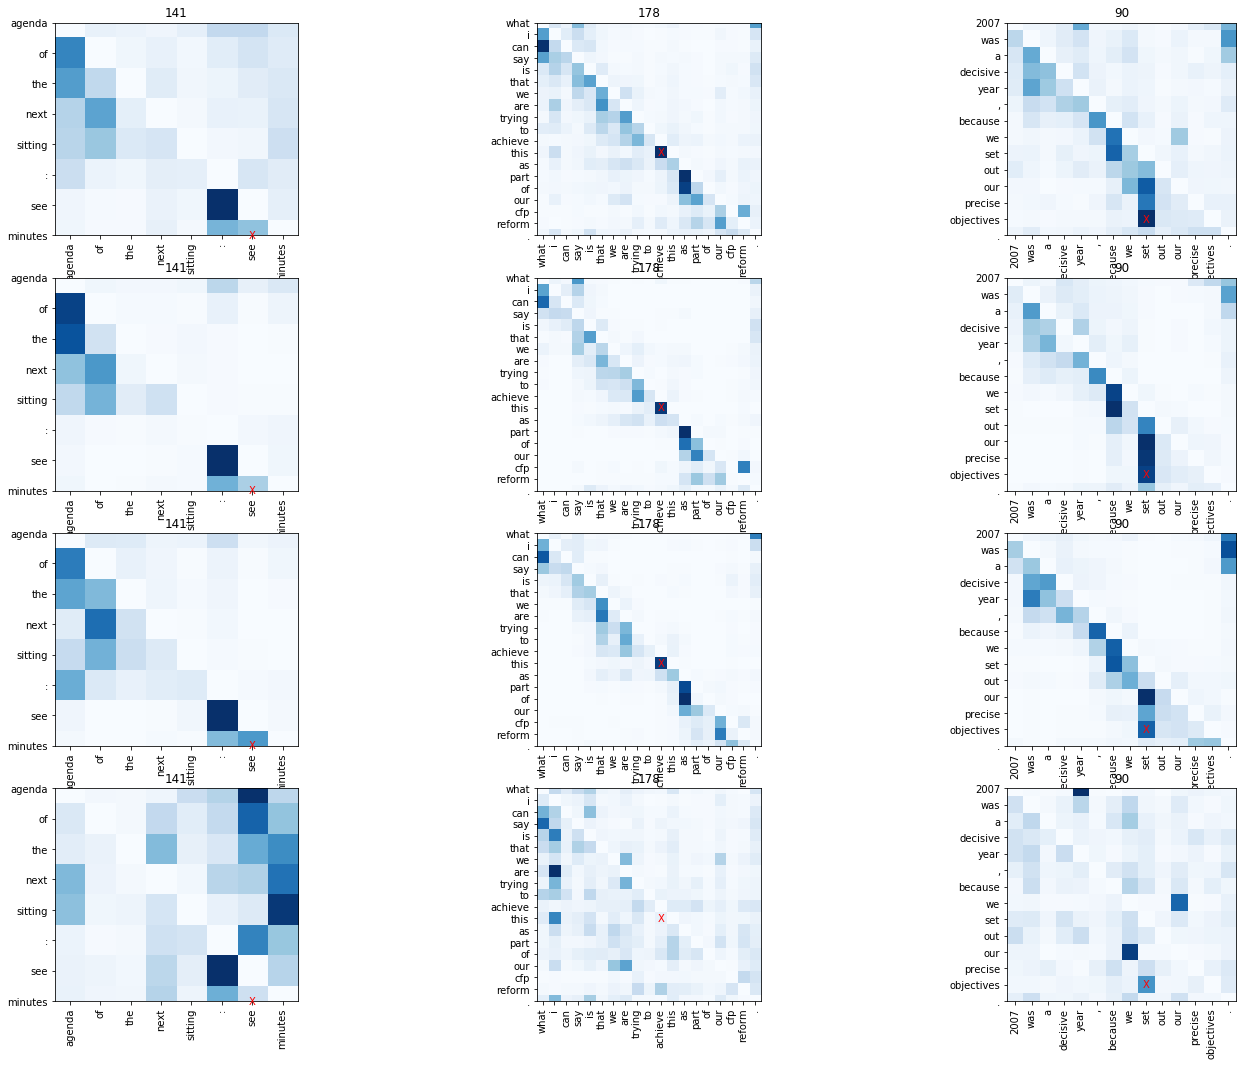

In [30]:
plot_head2(viss,words_lists,[7, 6, 3], [9, 9, 8], dependency_rels, 'object-d2p')

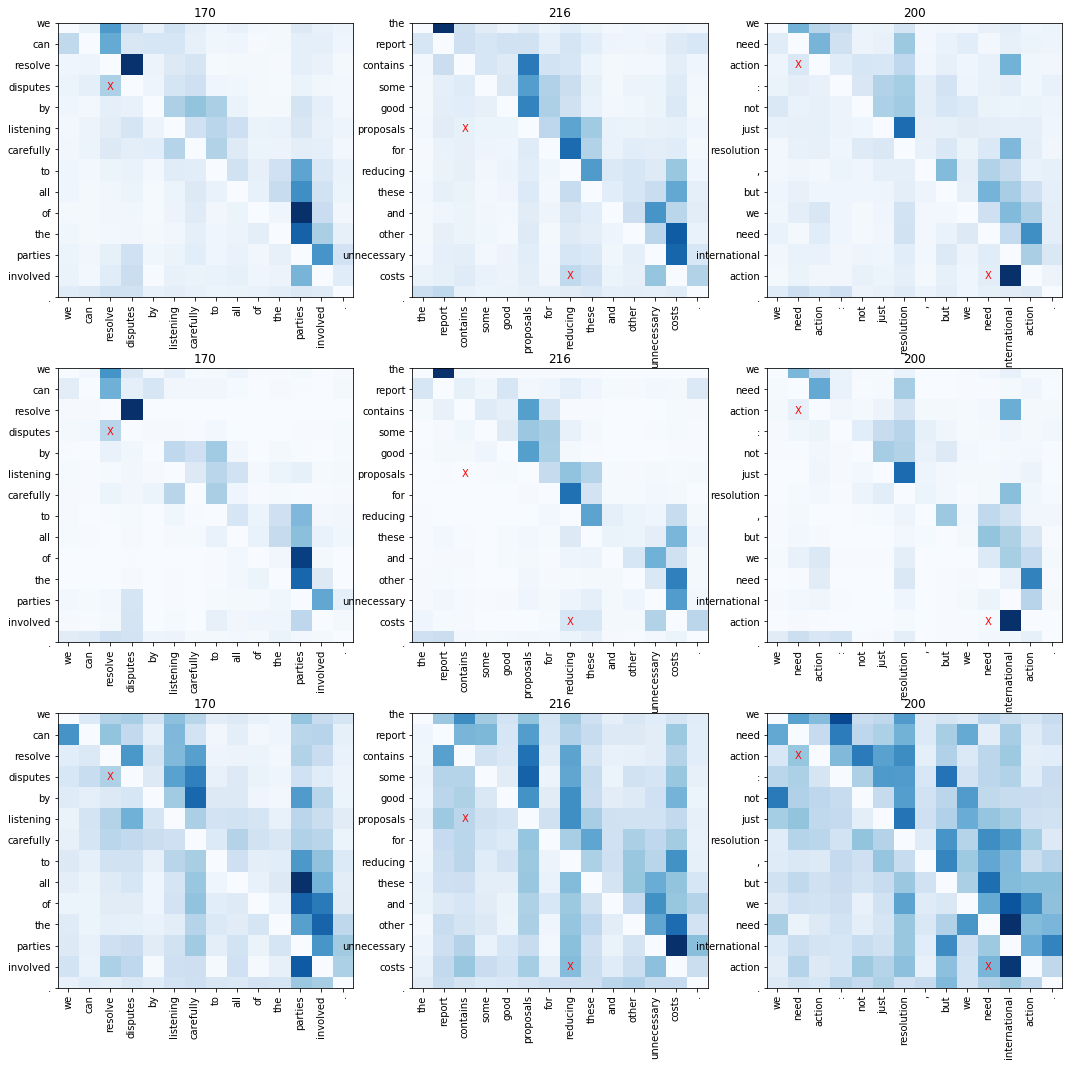

In [37]:
plot_head2(viss,words_lists,[7, 0], [10, 8], dependency_rels, 'object-d2p')

## auxiliary d2p (dev: 87.9 %, test: 90.3%)

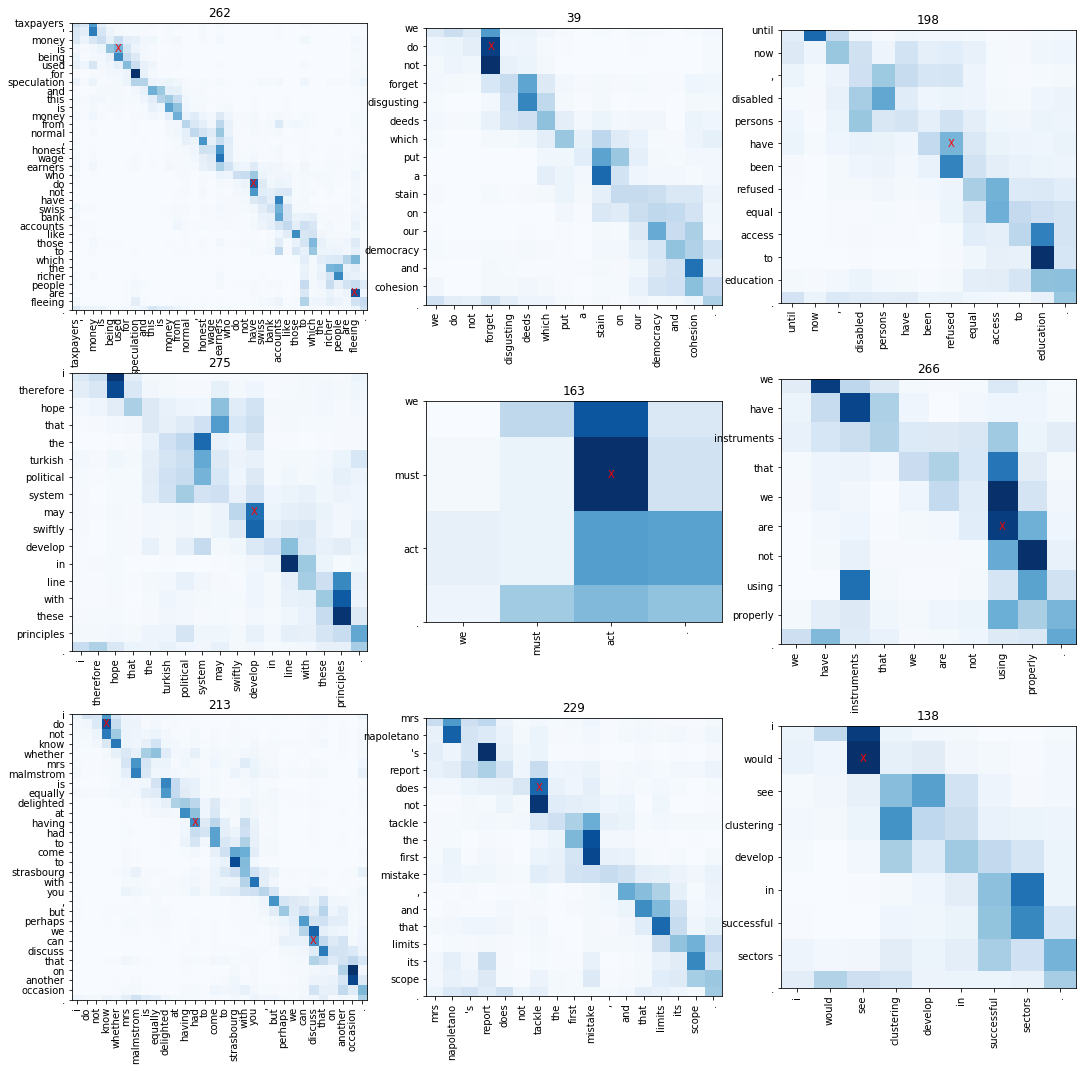

In [25]:
plot_head(viss,words_lists,[3, 7, 5, 8, 6, 5, 4, 7],[ 9,  6,  7,  5,  5,  0,  5, 10], dependency_rels, 'auxiliary-d2p')

In [ ]:
plot_head2(viss,words_lists,[3, 7, 5, 8, 6, 5, 4, 7],[ 9,  6,  7,  5,  5,  0,  5, 10], dependency_rels, 'auxiliary-d2p')

## Adjective modifier d2p : (dev: 83.9 %, test: 84.0%)


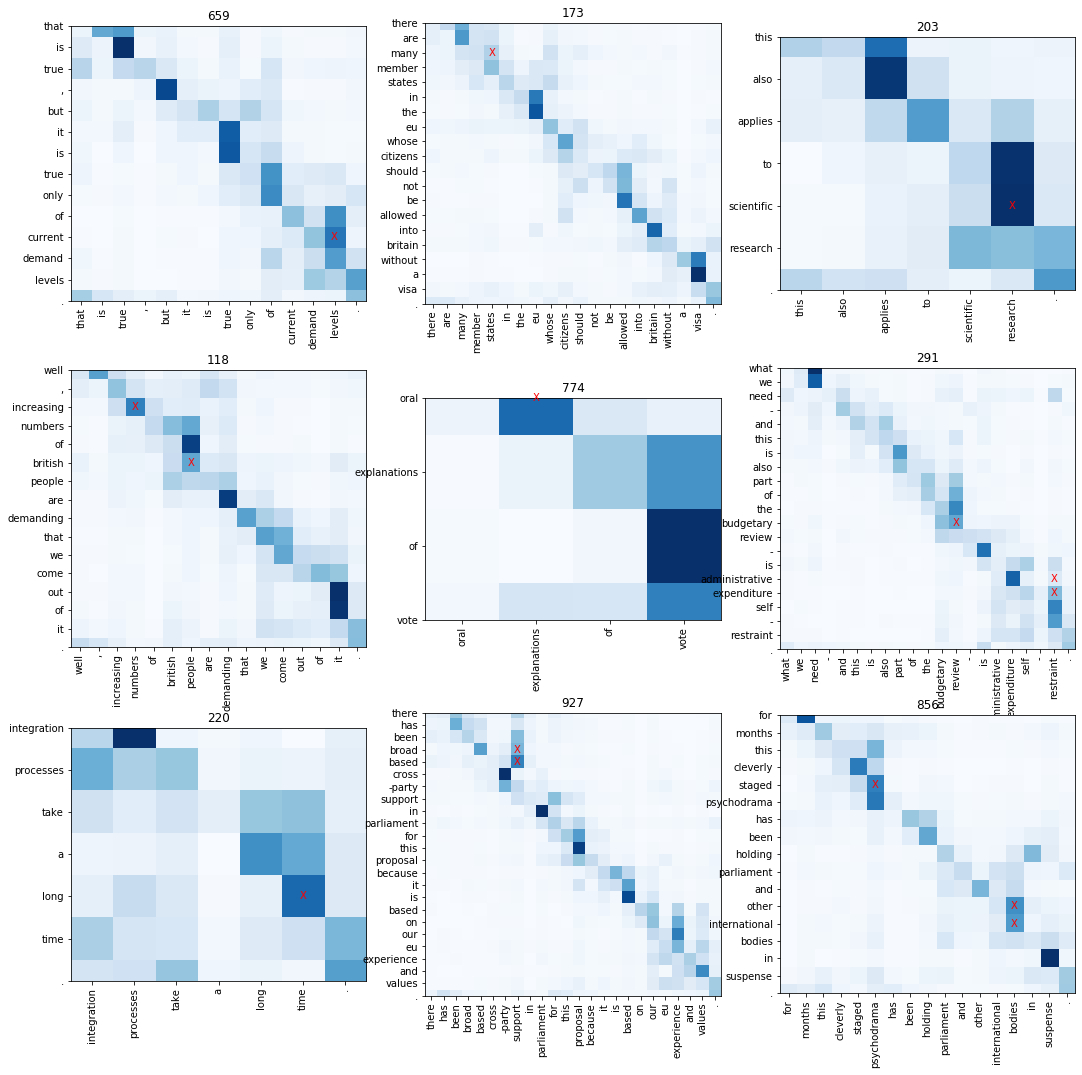

In [34]:
plot_head(viss,words_lists,[3, 7, 5, 8, 7, 0],[ 9, 10,  7,  5,  6,  8], dependency_rels, 'adj-modifier-d2p')

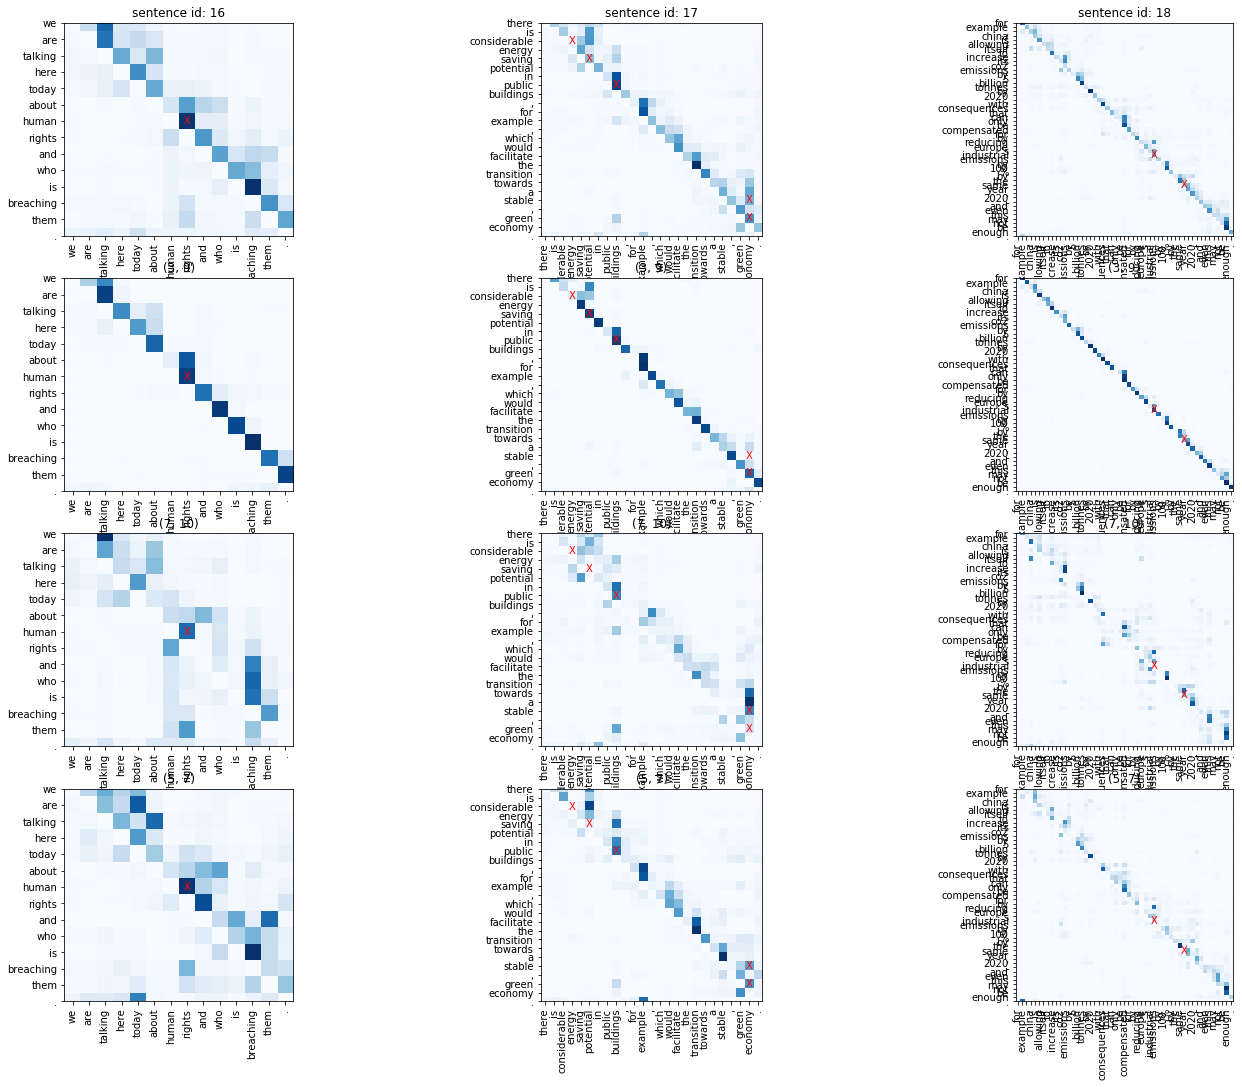

In [13]:
plot_head2(viss,words_lists, [3, 7, 5], [9, 10, 7], dependency_rels, 'adj-modifier-d2p')

## Determiner d2p (dev: 89.4%, test: 90.4%)


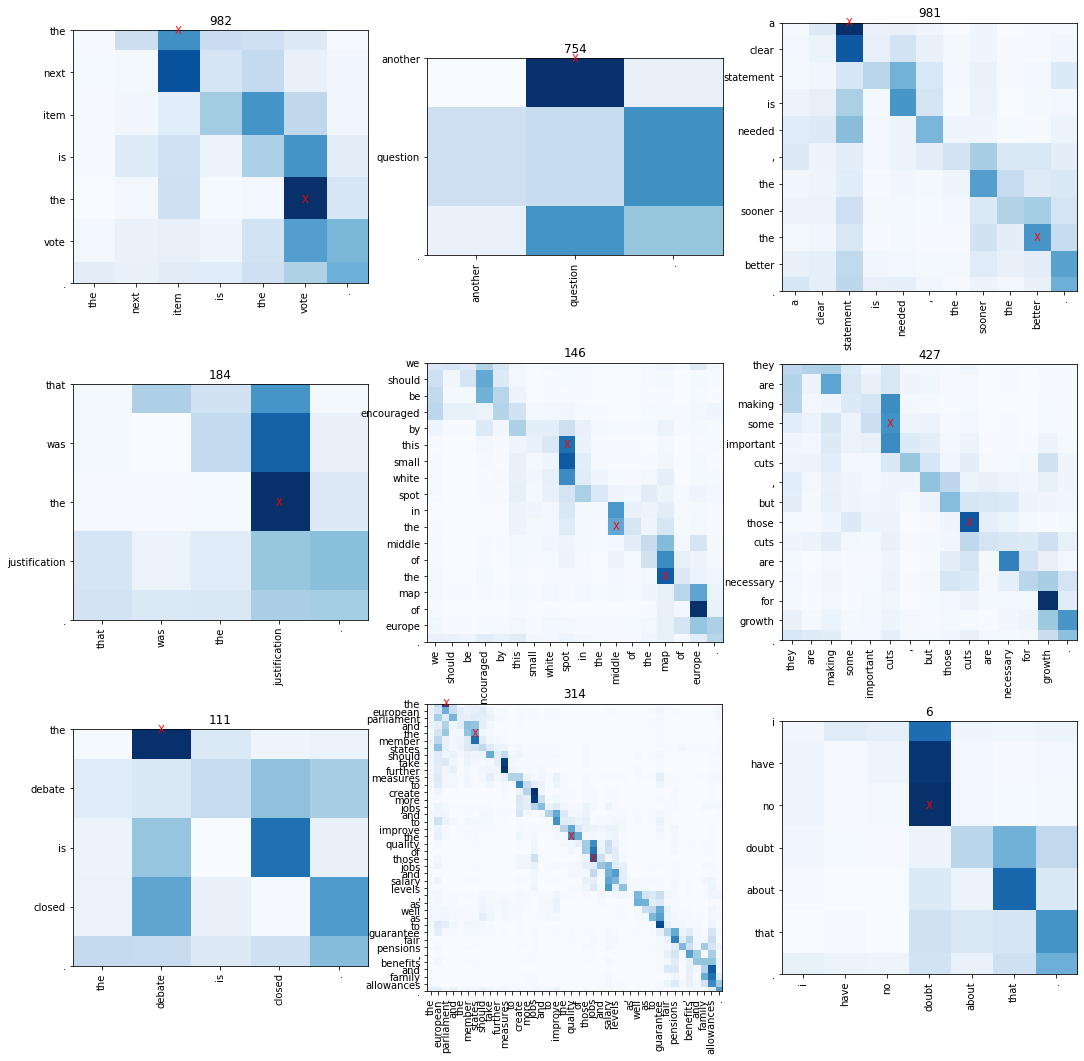

In [17]:
plot_head(viss,words_lists,[7, 3, 4, 8], [10,  9,  5, 10], dependency_rels, 'determiner-d2p')

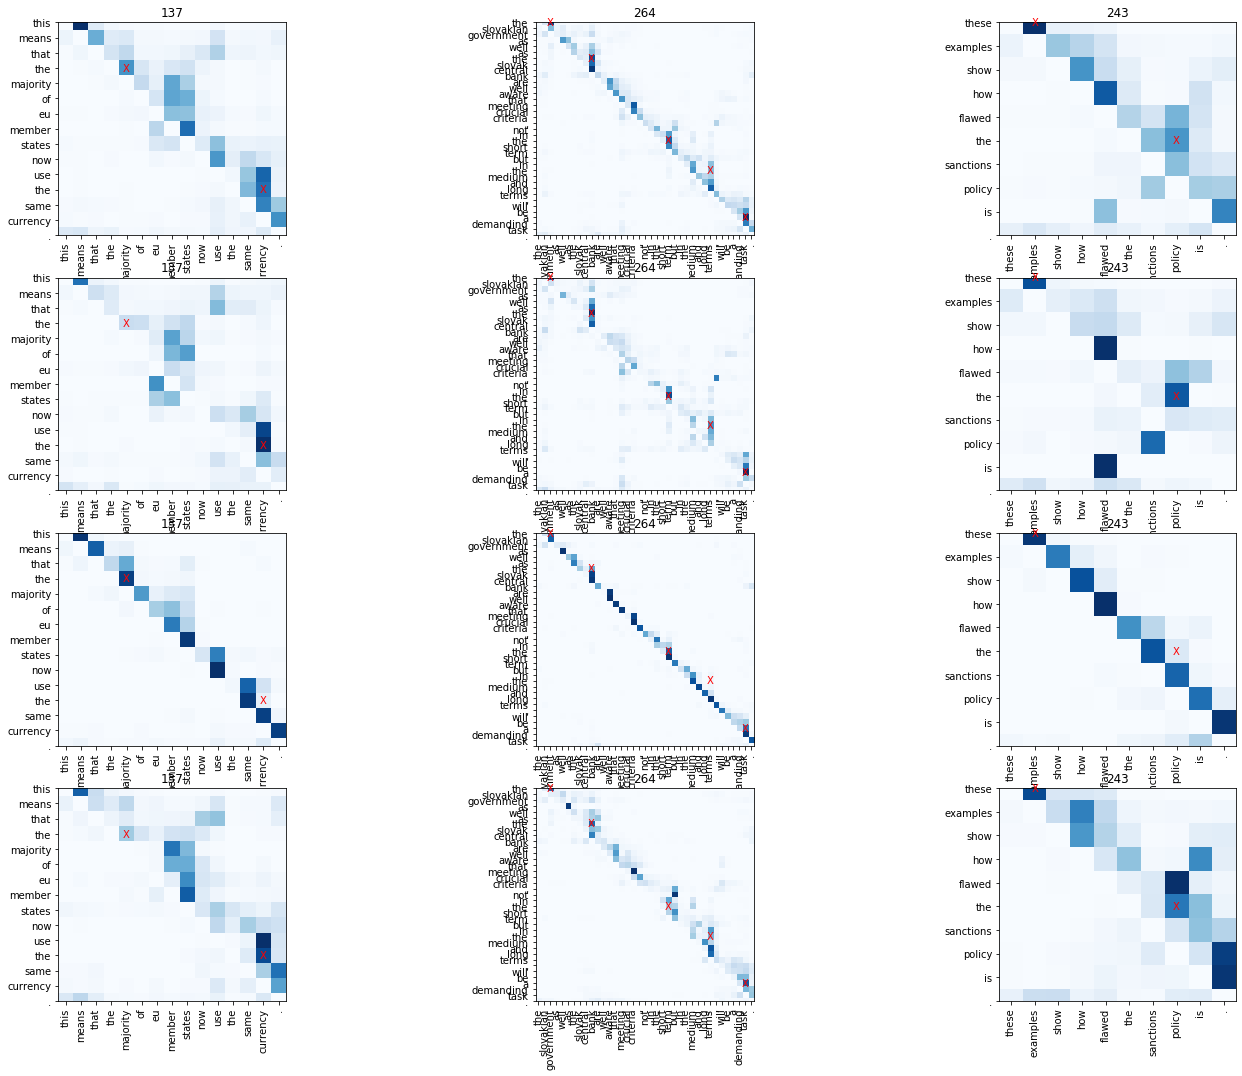

In [36]:
plot_head2(viss,words_lists,[7, 3, 4], [10, 9, 5],dependency_rels,'determiner-d2p')

## Clausal subject p2d (dev: 81.5%, test: 42.9%)

### Copula rearangment (dev: 50%, test: 40%)

only 35 times in test set

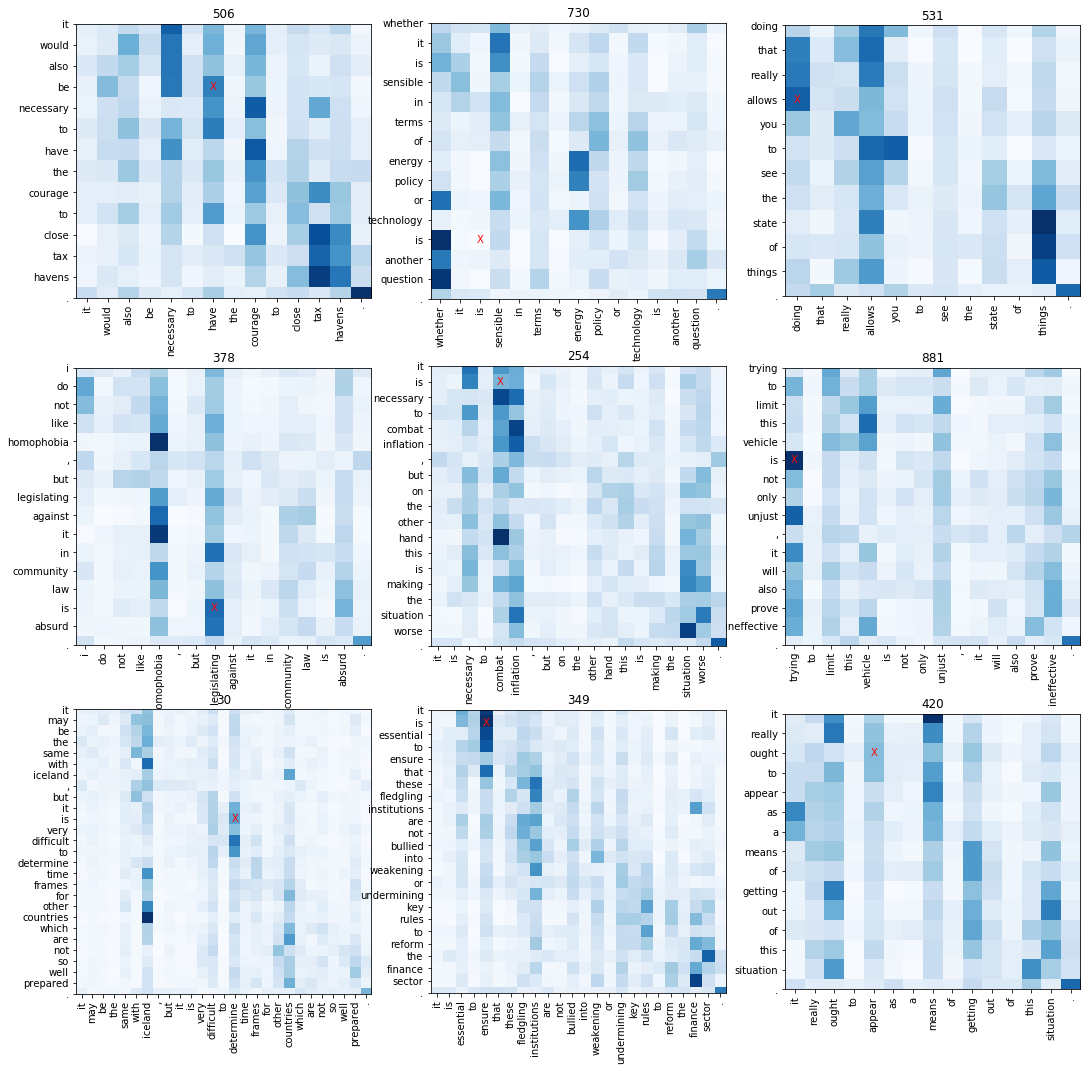

In [13]:
plot_head(viss,words_lists,[8, 0, 0, 0],[10,  8,  5,  1], dependency_rels, 'clausal subject-p2d')

## Adjective clause p2d (dev: 46.7%, test: 47.7%)

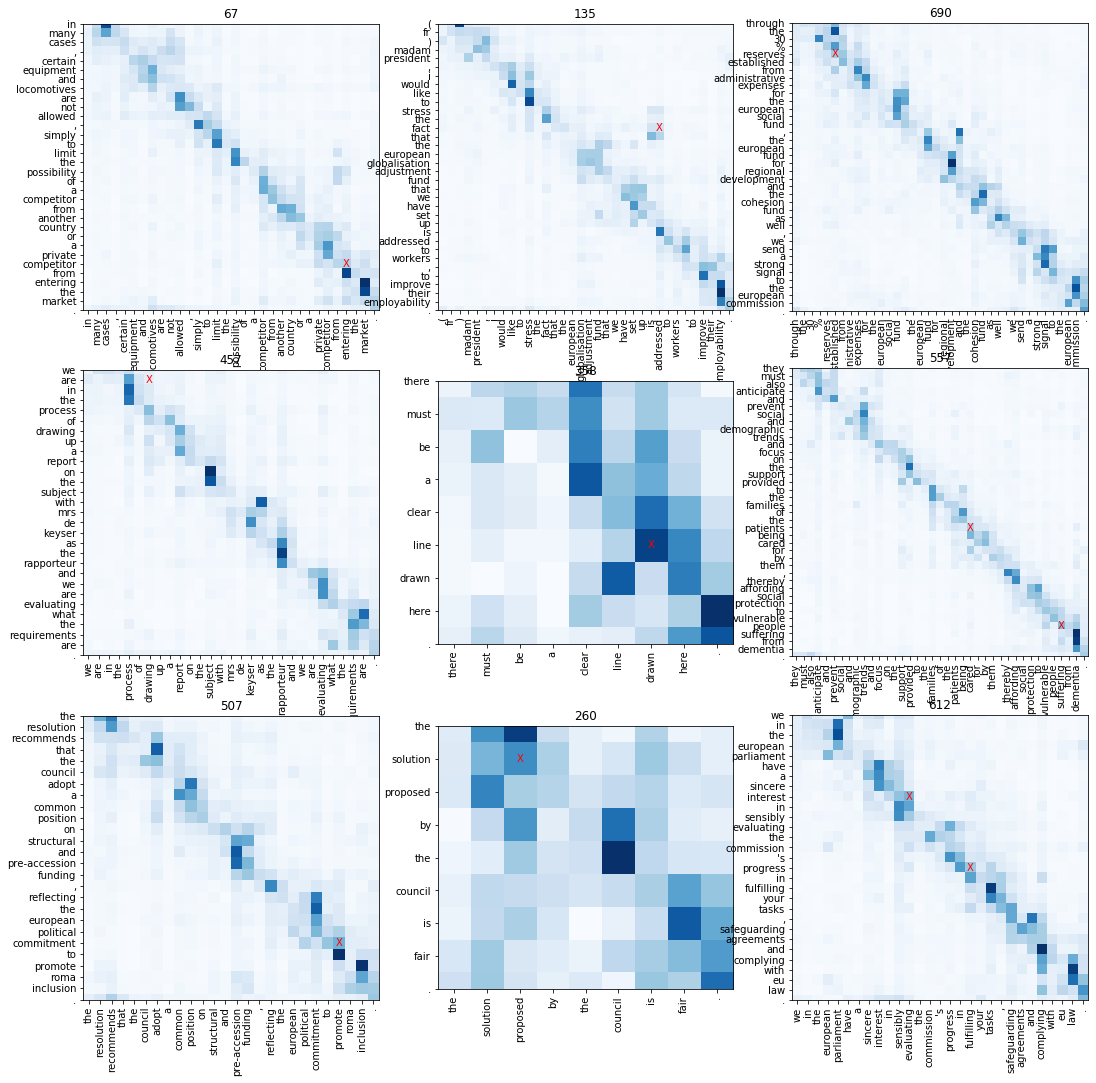

In [19]:
plot_head(viss,words_lists,[4, 6, 5, 7, 7, 0, 3, 0, 0],[ 5,  5,  7,  1,  6,  8,  3, 11,  5], dependency_rels, 'adj-clause-p2d')

## All d2p (dev: 48.6% , test: 48.1%)

### Copula rearanged (dev : 47.0%,  test: 46.4%)

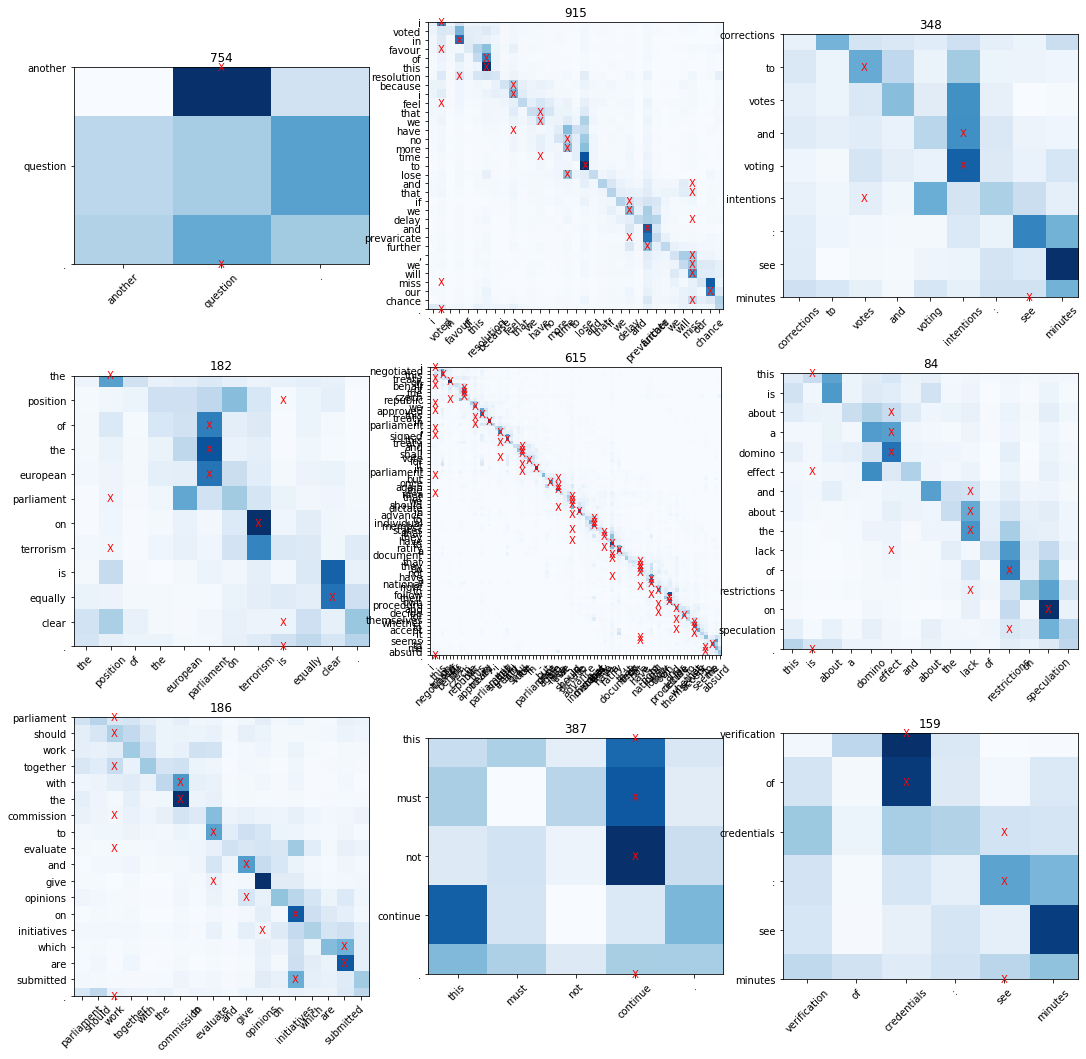

In [29]:
plot_head(viss,words_lists,[3, 7, 6, 8, 4, 3, 0, 0],[ 9, 10,  5,  5,  5, 10,  8, 11], dependency_rels, 'all-d2p')

## Subject + determiner common head

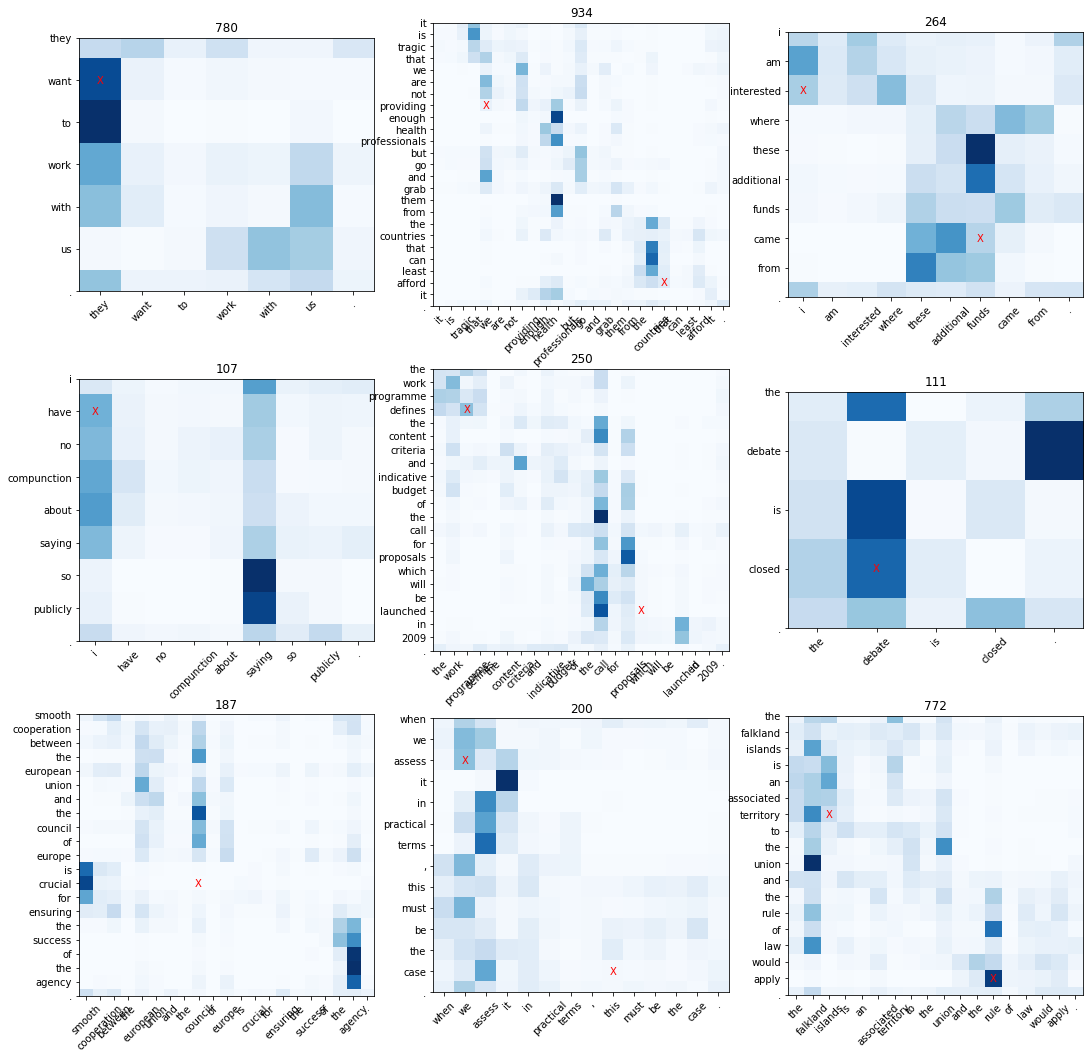

In [10]:
plot_head(viss,words_lists,[8],[10], dependency_rels, 'subject-p2d')

## Adj modifier and detrminer common head

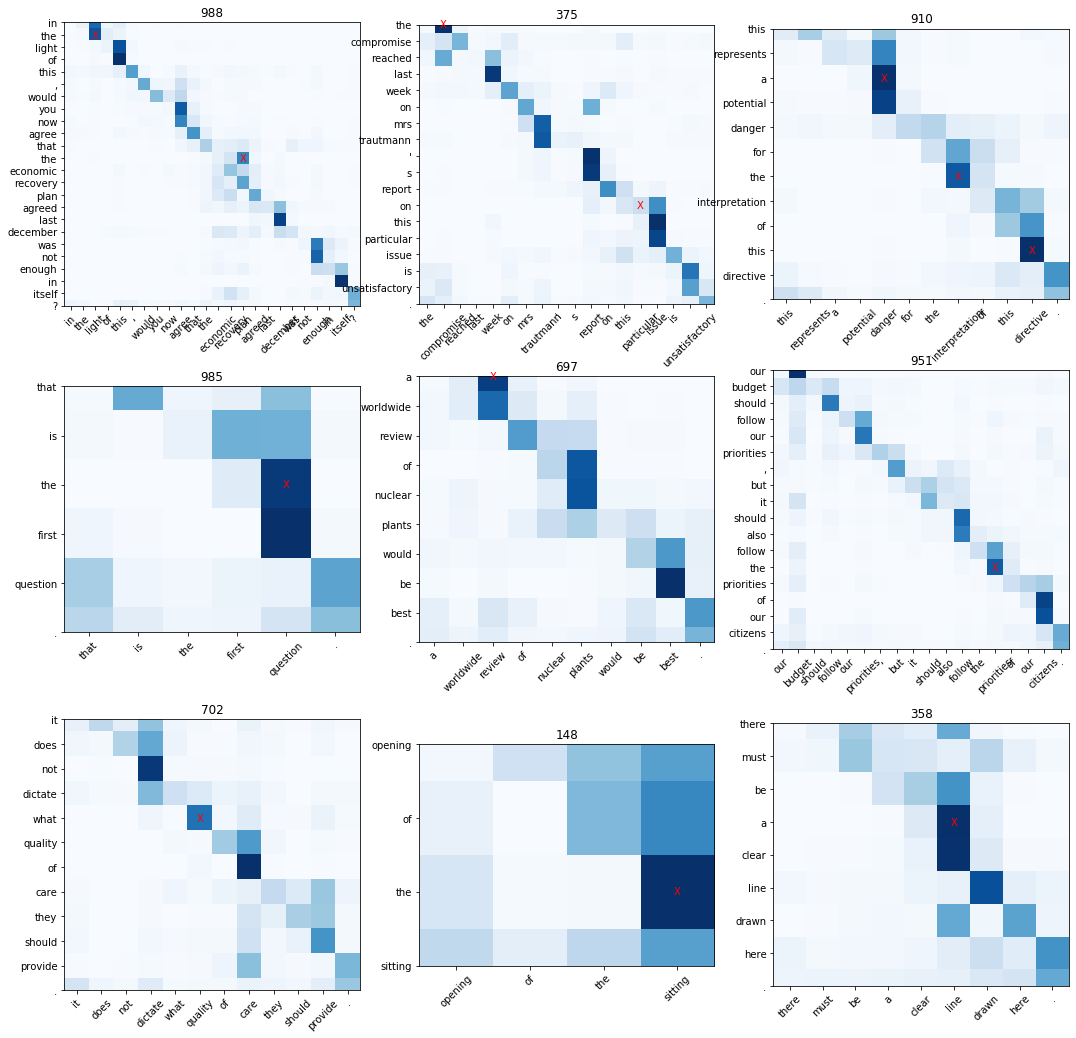

In [11]:
plot_head(viss,words_lists,[3,7],[9,10], dependency_rels, 'determiner-d2p')

In [ ]:
'adj-modifier-d2p': RelData([3, 7, 5], [9, 10, 7],False, True)

## Evaluate syntactic alignment

In [128]:
def average_heads(all_matrices, ls, hs):
    return np.average(all_matrices[ls,hs,:,:], axis=0)

def uas_from_matrices(matrices, dep_rels, req_rel_type=None):
    retrived = defaultdict(int)
    total = defaultdict(int)
    for matrix, dep_rel in zip(matrices, dep_rels):
        retr_pairs = set(zip(range(matrix.shape[0]), np.argmax(matrix, axis=1)))
        for rel_type, rel_pairs in dep_rel.items():
            retrived[rel_type] += len(set(rel_pairs).intersection(retr_pairs) )
            total[rel_type] += len(set(rel_pairs))
    if req_rel_type:
        if total[req_rel_type +'-p2d'] > 0:
            relp2d = req_rel_type + '-p2d'
            print(f"UAS for {relp2d} : {retrived[relp2d]/total[relp2d]}")
        if total[req_rel_type +'-d2p'] > 0:
            reld2p = req_rel_type + '-d2p'
            print(f"UAS for {reld2p} : {retrived[reld2p]/total[reld2p]}")
    else:
        for k in sorted(retrived.keys()):
            if total[k] > 0:
                print(f"UAS for {k} : {retrived[k]/total[k]} (number of relations: {total[k]})")
            else:
                print(f"No relations for {k}")
                

def ranking_fit(matrices, dep_rels, req_rel, req_rel_type=None):
    gold_scores = []
    n_gold = 0 
    attention_scores = []
    for matrix, dep_rel in zip(matrices, dep_rels):
        gold_matrix = np.zeros_like(matrix)
        for i, j in dep_rel[req_rel]:
            gold_matrix[i, j] = 1.
            n_gold +=1
            
        matrix /= matrix.sum()
            
        gold_scores += list(gold_matrix.ravel())
        attention_scores += list(matrix.ravel())
        

    attention_scores_ranks = np.argsort(attention_scores)
    gold_scores = np.array(gold_scores)
    

    prec = gold_scores[attention_scores_ranks[-n_gold:]].sum() / len(attention_scores_ranks[-n_gold:])
    prec5 = gold_scores[attention_scores_ranks[-(n_gold*5):]].sum() / n_gold
    prec5p = gold_scores[attention_scores_ranks[-int(len(attention_scores)/20):]].sum() / (len(attention_scores)/20)
    attention_scores_ranks = scipy.stats.rankdata(attention_scores)
    attention_scores_ranks /= attention_scores_ranks.mean()
    pb_r, _ = scipy.stats.pearsonr(gold_scores*len(gold_scores), scipy.stats.rankdata(attention_scores))
    
    fpr, tpr, _ = sklearn.metrics.roc_curve(gold_scores,attention_scores)
    gini = 2 * sklearn.metrics.auc(fpr,tpr) -1
    
    print(f"Attention precision: {prec}")
    print(f"Attention precision@5: {prec5}")
    print(f"Attention precision@5p: {prec5p}")
    print(f"Point biserial R: {pb_r}")
    print(f"Gini coeff: {gini}")

In [64]:
 x = np.array([3, 1, 2])

In [67]:
np.argsort(x)

array([1, 2, 0])

In [66]:
x[np.argsort(x)]

array([1, 2, 3])

In [54]:
np.argsort([3, 4 ,3, 5, 5, 6, 1,2])

array([6, 7, 0, 2, 1, 3, 4, 5])

## Direction change 

In [129]:
gen = (average_heads(np.array(all_ms),[7, 6, 4, 5, 3], [9, 9, 6, 3, 8]) for all_ms in viss.values())

uas_from_matrices(gen, dependency_rels, 'object')

UAS for object-p2d : 0.02806122448979592
UAS for object-d2p : 0.8443877551020408


In [130]:
gen = (average_heads(np.array(all_ms),[7, 6, 4, 5, 3], [9, 9, 6, 3, 8]) for all_ms in viss.values())
ranking_fit(gen, dependency_rels, 'object-d2p')

Attention precision: 0.058673469387755105
Attention precision@5: 0.2780612244897959
Attention precision@5p: 0.022833680726488115
Point biserial R: 0.058898739075616505
Gini coeff: 0.9198153335460051


In [131]:
gen = (average_heads(np.array(all_ms),[7, 4, 3, 3, 0, 5, 2, 9], [10, 5, 10, 9, 8, 0, 11, 1]) for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'object')

UAS for object-p2d : 0.7627551020408163
UAS for object-d2p : 0.03826530612244898


In [132]:
gen = (average_heads(np.array(all_ms),[7, 4, 3, 3, 0, 5, 2, 9], [10, 5, 10, 9, 8, 0, 11, 1]) for all_ms in viss.values())
ranking_fit(gen, dependency_rels, 'object-p2d')

Attention precision: 0.04081632653061224
Attention precision@5: 0.22448979591836735
Attention precision@5p: 0.02255436964726502
Point biserial R: 0.059254485338062005
Gini coeff: 0.9253709850283149


In [123]:
gen = (average_heads(np.array(all_ms),[7, 4, 3, 3, 0, 5, 2, 9], [10, 5, 10, 9, 8, 0, 11, 1])*average_heads(np.array(all_ms),[7, 6, 4, 5, 3], [9, 9, 6, 3, 8]).transpose() for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'object')

UAS for object-p2d : 0.7397959183673469
UAS for object-d2p : 0.04081632653061224


In [133]:
gen = (average_heads(np.array(all_ms),[7, 4, 3, 3, 0, 5, 2, 9], [10, 5, 10, 9, 8, 0, 11, 1])*average_heads(np.array(all_ms),[7, 6, 4, 5, 3], [9, 9, 6, 3, 8]).transpose() for all_ms in viss.values())
ranking_fit(gen, dependency_rels, 'object-p2d')

Attention precision: 0.1836734693877551
Attention precision@5: 0.48214285714285715
Attention precision@5p: 0.025068169360272886
Point biserial R: 0.060845484617642526
Gini coeff: 0.9502174512852823


In [98]:
gen = (average_heads(np.array(all_ms),[7, 6, 4, 5, 3], [9, 9, 6, 3, 8]).transpose() for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'object')

UAS for object-p2d : 0.5102040816326531
UAS for object-d2p : 0.04846938775510204


### Determiner

In [134]:
gen = (average_heads(np.array(all_ms),[7, 3, 4, 8], [10, 9, 5, 10]) for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'determiner')

UAS for determiner-p2d : 0.00963855421686747
UAS for determiner-d2p : 0.9433734939759036


In [135]:
gen = (average_heads(np.array(all_ms),[7, 3, 4, 8], [10, 9, 5, 10]) for all_ms in viss.values())
ranking_fit(gen, dependency_rels, 'determiner-d2p')

Attention precision: 0.1686746987951807
Attention precision@5: 0.6313253012048192
Attention precision@5p: 0.05579238807481347
Point biserial R: 0.09034002076228581
Gini coeff: 0.9703124386308457


In [136]:
gen = (average_heads(np.array(all_ms),[5, 1, 2, 8, 4, 6, 3, 9], [6, 4, 1, 6, 10, 2, 2, 6]) for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'determiner')

UAS for determiner-p2d : 0.6987951807228916
UAS for determiner-d2p : 0.0024096385542168677


In [137]:
gen = (average_heads(np.array(all_ms),[5, 1, 2, 8, 4, 6, 3, 9], [6, 4, 1, 6, 10, 2, 2, 6]) for all_ms in viss.values())
ranking_fit(gen, dependency_rels, 'determiner-p2d')

Attention precision: 0.06867469879518072
Attention precision@5: 0.27590361445783135
Attention precision@5p: 0.042664767351327945
Point biserial R: 0.08643221088423156
Gini coeff: 0.9283399385088194


In [138]:
gen = (average_heads(np.array(all_ms),[5, 1, 2, 8, 4, 6, 3, 9], [6, 4, 1, 6, 10, 2, 2, 6])*average_heads(np.array(all_ms),[7, 3, 4, 8], [10, 9, 5, 10]).transpose() for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'determiner')

UAS for determiner-p2d : 0.7421686746987952
UAS for determiner-d2p : 0.008433734939759036


In [139]:
gen = (average_heads(np.array(all_ms),[5, 1, 2, 8, 4, 6, 3, 9], [6, 4, 1, 6, 10, 2, 2, 6])*average_heads(np.array(all_ms),[7, 3, 4, 8], [10, 9, 5, 10]).transpose() for all_ms in viss.values())
ranking_fit(gen, dependency_rels, 'determiner-p2d')

Attention precision: 0.26506024096385544
Attention precision@5: 0.763855421686747
Attention precision@5p: 0.05656049354267698
Point biserial R: 0.09107396260002179
Gini coeff: 0.9781954664228696


In [140]:
gen = (average_heads(np.array(all_ms),[7, 3, 4, 8], [10, 9, 5, 10]).transpose() for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels, 'determiner')

UAS for determiner-p2d : 0.7698795180722892
UAS for determiner-d2p : 0.02891566265060241
